In [28]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Tiff Display

In [29]:
def show_tiff(tiff_path, cmap='terrain'):
    """Display a single TIFF in Jupyter"""
    with rasterio.open(tiff_path) as src:
        data = src.read(1).astype(float)
        if src.nodata is not None:
            data[data == src.nodata] = np.nan

        plt.figure(figsize=(10, 8))
        plt.imshow(data, cmap=cmap)
        plt.colorbar(label='Height (m)')
        plt.title(Path(tiff_path).stem)
        plt.axis('off')
        plt.show()

def show_tiff_pts(tiff_path, pts=None, cmap='terrain', pt_color='red', pt_size=1):
    """Display a TIFF with optional points overlay"""
    with rasterio.open(tiff_path) as src:
        data = src.read(1).astype(float)
        if src.nodata is not None:
            data[data == src.nodata] = np.nan

        plt.figure(figsize=(10, 8))
        plt.imshow(data, cmap=cmap, extent=[src.bounds.left, src.bounds.right,
                                           src.bounds.bottom, src.bounds.top])

        # Overlay points if provided
        if pts is not None and len(pts) > 0:
            # Reproject points to match raster CRS if needed
            if pts.crs != src.crs:
                pts_proj = pts.to_crs(src.crs)
            else:
                pts_proj = pts

            plt.scatter(pts_proj.geometry.x, pts_proj.geometry.y,
                       c=pt_color, s=pt_size, alpha=0.7, edgecolors='none')
            print(f"Displayed {len(pts)} points")

        plt.colorbar(label='Height (m)')
        plt.title(Path(tiff_path).stem)
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.show()

Tiff Inspection

In [30]:
def inspect_tiff(tiff_path):
    """Comprehensive inspection of TIFF file contents"""

    print(f"🔍 INSPECTING: {Path(tiff_path).name}")
    print("="*60)

    with rasterio.open(tiff_path) as src:
        # Basic file info
        print(f"📋 BASIC INFO:")
        print(f"  Dimensions: {src.width} x {src.height}")
        print(f"  Bands: {src.count}")
        print(f"  Data types: {src.dtypes}")
        print(f"  CRS: {src.crs}")
        print(f"  Resolution: {src.res}")
        print(f"  Bounds: {src.bounds}")
        print(f"  NoData: {src.nodata}")

        # Metadata
        print(f"\n📝 METADATA:")
        if src.tags():
            for key, value in src.tags().items():
                print(f"  {key}: {value}")
        else:
            print("  No metadata found")

        # Band descriptions
        print(f"\n📊 BAND INFORMATION:")
        for i in range(1, src.count + 1):
            print(f"\n  BAND {i}:")

            # Band metadata
            band_tags = src.tags(i)
            if band_tags:
                for key, value in band_tags.items():
                    print(f"    {key}: {value}")

            # Read sample data
            data = src.read(i)

            # Handle nodata
            if src.nodata is not None:
                valid_data = data[data != src.nodata]
            else:
                valid_data = data.flatten()

            if len(valid_data) > 0:
                print(f"    Data type: {data.dtype}")
                print(f"    Valid pixels: {len(valid_data):,} / {data.size:,} ({len(valid_data)/data.size*100:.1f}%)")
                print(f"    Range: {valid_data.min():.3f} to {valid_data.max():.3f}")
                print(f"    Mean: {valid_data.mean():.3f}")
                print(f"    Std: {valid_data.std():.3f}")

                # Check for common LiDAR data patterns
                unique_vals = np.unique(valid_data)
                if len(unique_vals) < 20:
                    print(f"    Unique values: {unique_vals}")
                    print(f"    → Likely classification/categorical data")
                elif valid_data.max() < 100:
                    print(f"    → Possibly intensity, return info, or relative heights")
                elif 100 <= valid_data.max() < 5000:
                    print(f"    → Likely elevation data (meters)")
                else:
                    print(f"    → Possibly elevation in different units")
            else:
                print(f"    No valid data found")

        # Color interpretation (if available)
        print(f"\n🎨 COLOR INTERPRETATION:")
        for i in range(1, src.count + 1):
            color_interp = src.colorinterp[i-1]
            print(f"  Band {i}: {color_interp}")

        # Overviews
        print(f"\n🔍 OVERVIEWS:")
        for i in range(1, src.count + 1):
            overviews = src.overviews(i)
            if overviews:
                print(f"  Band {i}: {len(overviews)} overview levels")
            else:
                print(f"  Band {i}: No overviews")

Process Initiation

In [31]:
from rasterio.warp import reproject, Resampling, calculate_default_transform
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import NearestNeighbors
from pykrige.ok import OrdinaryKriging
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.transform import from_bounds
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import box
from rasterio.mask import mask

DATA_DIR = Path("data")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

TARGET_CRS = 'EPSG:32632'  # UTM 32N
resolution = 10  # meters
NODATA = -9999
saocom_files = list(DATA_DIR.glob("verona_v2*"))

SAOCOM QA

In [32]:

def clean_bad_saocom_points(points_gdf, neighbor_distance=250, height_threshold=100):
    """
    Remove obvious bad points - like -300m in area where everything is ~200m
    """
    print(f"Cleaning: Starting with {len(points_gdf)} points")

    if len(points_gdf) < 10:
        return points_gdf

    # Find neighbors within distance
    coords = np.column_stack([points_gdf['x'], points_gdf['y']])
    heights = points_gdf['height'].values

    nbrs = NearestNeighbors(radius=neighbor_distance).fit(coords)
    OK = OrdinaryKriging(points_gdf['x'], points_gdf['y'], points_gdf['height'],
                         variogram_model='power',  # or 'gaussian', 'exponential'
                        enable_plotting=False,
                        coordinates_type='euclidean'
)
    print(OK)
    bad_points = []

    for i, (x, y, height) in enumerate(zip(points_gdf['x'], points_gdf['y'], heights)):
        # Find neighbors within radius
        neighbor_indices = nbrs.radius_neighbors([[x, y]], return_distance=False)[0]
        neighbor_indices = neighbor_indices[neighbor_indices != i]  # Remove self

        if len(neighbor_indices) < 3:  # Need at least 3 neighbors
            continue

        neighbor_heights = heights[neighbor_indices]
        neighbor_median = np.median(neighbor_heights)

        # Check if point is way off from neighbors
        height_diff = abs(height - neighbor_median)

        if height_diff > height_threshold:
            bad_points.append(i)
            print(f"  Bad point: {height:.1f}m vs neighbors ~{neighbor_median:.1f}m (diff: {height_diff:.1f}m)")

    # Remove bad points
    if bad_points:
        clean_points = points_gdf.drop(points_gdf.index[bad_points])
        print(f"Removed {len(bad_points)} obviously bad points")
    else:
        clean_points = points_gdf
        print("No obviously bad points found")

    print(f"Final: {len(clean_points)} points")
    return clean_points

In [33]:
"""Load SAOCOM point data"""
# Try different separators

df = pd.read_csv(saocom_files[0], sep=',')
# Standardize column names
cols = df.columns.str.upper().str.strip()
mapping = {'LAT': 'lat', 'LON': 'lon', 'HEIGHT': 'height', 'COHER': 'coherence'}

for old, new in mapping.items():
    if old in cols:
        df = df.rename(columns={old: new})

# Clean data
for col in ['lat', 'lon', 'height', 'coherence']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['lat', 'lon', 'height'])
df = df[df['coherence'] >= 0.3]  # Filter by coherence

# Convert to GeoDataFrame and reproject
geometry = [Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
gdf = gdf.to_crs(TARGET_CRS)
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
# gdf = qaqc_saocom_points(gdf, reference_dem_path=reference_dems['tinitaly'])
# gdf = clean_bad_saocom_points(gdf)


In [34]:
def read_saocom_csv(csv_path, coherence_threshold=0.3):
    """
    Read SAOCOM CSV data and apply coherence filtering.

    Parameters:
    -----------
    csv_path : str or Path
        Path to SAOCOM CSV file
    coherence_threshold : float
        Minimum coherence value to keep points

    Returns:
    --------
    geopandas.GeoDataFrame
        Projected point data in EPSG:32632
    """
    # Try to read CSV - handle different separators and formats
    with open(csv_path, 'r') as f:
        first_line = f.readline()

    columns = ['ID', 'SVET', 'LVET', 'LAT', 'LON', 'HEIGHT',
              'HEIGHT_WRT_DEM', 'SIGMA_HEIGHT', 'COHER']
    df = pd.read_csv(csv_path, sep=',', names=columns, skiprows=1)
    # Standardize column names (handle variations)
    column_mapping = {
        'LAT': 'LAT', 'LATITUDE': 'LAT', 'lat': 'LAT',
        'LON': 'LON', 'LONGITUDE': 'LON', 'lon': 'LON', 'LONG': 'LON',
        'HEIGHT': 'HEIGHT', 'ELEVATION': 'HEIGHT', 'ELEV': 'HEIGHT',
        'COHER': 'COHER', 'COHERENCE': 'COHER', 'COH': 'COHER'
    }

    # Clean column names and apply mapping
    df.columns = [col.strip().upper() for col in df.columns]
    df = df.rename(columns=column_mapping)

    # Convert to numeric
    for col in ['LAT', 'LON', 'HEIGHT', 'COHER']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remove invalid points
    df = df.dropna(subset=['LAT', 'LON', 'HEIGHT'])
    df = df[(df['LAT'] != 0) & (df['LON'] != 0)]

    # Apply coherence filter if available
    if 'COHER' in df.columns:
        df = df[df['COHER'] >= coherence_threshold]

    # Create GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in zip(df['LON'], df['LAT'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

    # Reproject to UTM 32N
    gdf_utm = gdf.to_crs('EPSG:32632')

    # Add UTM coordinates as columns
    gdf_utm['X'] = gdf_utm.geometry.x
    gdf_utm['Y'] = gdf_utm.geometry.y

    return gdf_utm

def points_to_raster(gdf, resolution=10, method='linear'):
    """
    Convert point data to a raster using interpolation.

    Parameters:
    -----------
    gdf : geopandas.GeoDataFrame
        Point data with X, Y, HEIGHT columns
    resolution : float
        Pixel size in meters
    method : str
        Interpolation method ('linear', 'nearest', 'cubic')

    Returns:
    --------
    tuple
        (raster_array, transform, bounds)
    """
    # Get bounds from the GeoDataFrame
    bounds = gdf.total_bounds
    xmin, ymin, xmax, ymax = bounds

    # Create grid using np.arange
    x = np.arange(xmin, xmax + resolution, resolution)
    y = np.arange(ymax, ymin - resolution, -resolution)
    grid_x, grid_y = np.meshgrid(x, y)

    # Extract point coordinates and values
    points = np.column_stack((gdf['X'].values, gdf['Y'].values))
    values = gdf['HEIGHT'].values

    # Interpolate
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    grid_values = griddata(points, values, grid_points, method=method, fill_value=np.nan)
    raster_array = grid_values.reshape(grid_x.shape)

    # Create transform
    transform = from_bounds(xmin, ymin, xmax, ymax, len(x), len(y))
    return raster_array, transform, (xmin, ymin, xmax, ymax)


def save_raster(array, transform, output_path, crs='EPSG:32632', nodata=-9999):
    """
    Save raster array to GeoTIFF.

    Parameters:
    -----------
    array : numpy.ndarray
        Raster data
    transform : rasterio.transform.Affine
        Geotransform
    output_path : str or Path
        Output file path
    crs : str
        Coordinate reference system
    nodata : float
        NoData value
    """
    # Replace NaN with nodata value
    array_out = array.copy()
    array_out[np.isnan(array_out)] = nodata

    # Write to file
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=array.shape[0],
        width=array.shape[1],
        count=1,
        dtype=array.dtype,
        crs=crs,
        transform=transform,
        nodata=nodata,
        compress='lzw'
    ) as dst:
        dst.write(array_out, 1)


def main():
    """
    Main conversion workflow
    """
    # Configuration
    config = {
        'input_csv': 'data/verona_v2.csv',  # <--- CHANGE THIS TO YOUR CSV FILE PATH
        'output_dir': Path('results/saocom_raster'),
        'resolution': 10,  # meters
        'coherence_threshold': 0.3,
        'interpolation_method': 'cubic',  # 'linear', 'nearest', or 'cubic'
    }

    # Create output directory
    config['output_dir'].mkdir(parents=True, exist_ok=True)

    # Step 1: Read and project CSV data
    gdf = read_saocom_csv(
        config['input_csv'],
        coherence_threshold=config['coherence_threshold']
    )

    # Save projected points for reference
    points_output = config['output_dir'] / "saocom_points_utm32n.gpkg"
    gdf.to_file(points_output, driver="GPKG")

    # Step 2: Convert to raster
    raster_array, transform, bounds = points_to_raster(
        gdf,
        resolution=config['resolution'],
        method=config['interpolation_method']
    )

    # Step 3: Save raster
    raster_output = config['output_dir'] / f"saocom_dem_utm32n_{config['resolution']}m.tif"
    save_raster(raster_array, transform, raster_output)

    # Step 4: Create visualization

# This block executes the main function when the cell is run
main()


66791


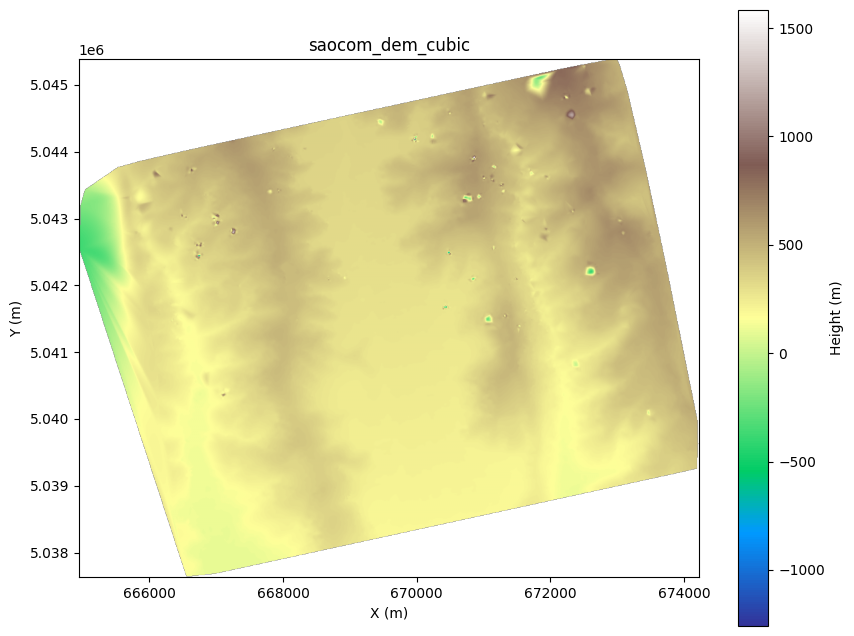

In [35]:
"""Convert points to regular grid"""
method = 'cubic'
# Define grid bounds
bounds = gdf.total_bounds
xmin, ymin, xmax, ymax = bounds

# Create grid
x = np.arange(xmin, xmax + resolution, resolution)
y = np.arange(ymax, ymin - resolution, -resolution)  # Flip Y direction
grid_x, grid_y = np.meshgrid(x, y)

# Interpolate
points_xy = np.column_stack([gdf['x'], gdf['y']])
values = gdf['height'].values
grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

grid_values = griddata(points_xy, values, grid_points, method=method, fill_value=NODATA)
saocom_grid = grid_values.reshape(grid_x.shape)

# Save as GeoTIFF
transform = from_bounds(xmin, ymin, xmax, ymax, len(x), len(y))

saocom_raster_path = RESULTS_DIR / f"saocom_dem_{method}.tif"
with rasterio.open(saocom_raster_path, 'w', driver='GTiff', height=saocom_grid.shape[0],
                   width=saocom_grid.shape[1], count=1, dtype='float32',
                   crs=TARGET_CRS, transform=transform, nodata=NODATA) as dst:
    dst.write(saocom_grid.astype('float32'), 1)
# show_tiff(saocom_raster_path)
show_tiff_pts(saocom_raster_path)



In [57]:
def process_reference_dem(dem_path, target_bounds, target_transform, target_width, target_height):
    """Reproject and resample DEM to target grid"""
    output_path = RESULTS_DIR / f"{dem_path.stem}_processed.tif"
    print(dem_path)
    with rasterio.open(dem_path) as src:
        if 'cor' in dem_path.name:
                data = src.read(1)
                unique_vals = np.unique(data)
                print(f"Unique values: {len(unique_vals)}")
                print(f"Sample: {unique_vals[:10]}")
        # Setup output profile
        profile = {
            'driver': 'GTiff',
            'dtype': 'float32',
            'width': target_width,
            'height': target_height,
            'count': 1,
            'crs': TARGET_CRS,
            'transform': target_transform,
            'nodata': NODATA
        }

        # Create output array
        output_array = np.full((target_height, target_width), NODATA, dtype=np.float32)

        # Reproject
        reproject(
            source=rasterio.band(src, 1),
            destination=output_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=TARGET_CRS,
            resampling=Resampling.cubic,
            src_nodata=src.nodata,
            dst_nodata=NODATA
        )
        # Check result
        valid_pixels = np.sum(output_array != NODATA)
        if valid_pixels > 0:
            valid_data = output_array[output_array != NODATA]

        # Save
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(output_array, 1)
        # show_tiff_pts(output_path)
    return output_path

reference_dems = {}
# if 'saocom_grid' in locals():
    # Get target grid from SAOCOM
bounds = [grid_x.min(), grid_y.min(), grid_x.max(), grid_y.max()]
transform = from_bounds(*bounds, grid_x.shape[1], grid_x.shape[0])

# Find and process reference DEMs
dem_patterns = {
    'tinitaly': '*tinitaly*',
    'copernicus': '*GLO30*',
    'lidar_crop': '*lidar*',
    'lclu': '*LCLU*',
    'corine_clip': '*corine*'
}

for name, pattern in dem_patterns.items():
    dem_files = list(DATA_DIR.glob(f"{pattern}.tif")) + list(DATA_DIR.glob(f"{pattern}.TIF"))
    if dem_files:
        processed_path = process_reference_dem(
            dem_files[0], bounds, transform, grid_x.shape[1], grid_x.shape[0]
        )
        reference_dems[name] = processed_path

print(reference_dems)
# create_qaqc_report(gdf, cleaned_points, RESULTS_DIR)

data\tinitaly.tif
data\GLO30.tif
data\lidar_crop.tif
data\lclu_crop.tif
data\corine_clip.tif
Unique values: 12
Sample: [ 0  2  3 15 17 18 20 21 23 24]
{'tinitaly': WindowsPath('results/tinitaly_processed.tif'), 'copernicus': WindowsPath('results/GLO30_processed.tif'), 'lidar_crop': WindowsPath('results/lidar_crop_processed.tif'), 'lclu': WindowsPath('results/lclu_crop_processed.tif'), 'corine_clip': WindowsPath('results/corine_clip_processed.tif')}


In [37]:

def calibrate_saocom(saocom_path, tinitaly_path):
    """Calibrate SAOCOM heights using TINITALY reference"""

    # Get SAOCOM bounds
    with rasterio.open(saocom_path) as src:
        saocom_bounds = src.bounds
        clip_geom = box(*saocom_bounds)

    # Clip TINITALY to SAOCOM extent
    with rasterio.open(tinitaly_path) as src:
        clipped_data, _ = rasterio.mask.mask(src, [clip_geom], crop=True)
        tinitaly_data = clipped_data[0]
        tinitaly_valid = tinitaly_data[(tinitaly_data != src.nodata) & (~np.isnan(tinitaly_data))]

    # Get SAOCOM average
    with rasterio.open(saocom_path) as src:
        saocom_data = src.read(1).astype(float)
        saocom_valid = saocom_data[(saocom_data != src.nodata) & (~np.isnan(saocom_data))]

    # Calculate bias and adjustment
    tinitaly_avg = np.mean(tinitaly_valid)
    saocom_avg = np.mean(saocom_valid)
    adjustment = tinitaly_avg - saocom_avg


    # Apply adjustment to SAOCOM
    with rasterio.open(saocom_path) as src:
        data = src.read(1).astype(np.float32)
        valid_mask = (data != src.nodata) & (~np.isnan(data))
        data[valid_mask] += adjustment

        # Save adjusted version
        output_path = Path(saocom_path).parent / f"{Path(saocom_path).stem}_calibrated.tif"
        profile = src.profile.copy()

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data, 1)

    print(f"Saved calibrated SAOCOM: {output_path.name}")
    return output_path

calibrated_saocom = calibrate_saocom(saocom_raster_path, reference_dems['tinitaly'])

Saved calibrated SAOCOM: saocom_dem_cubic_calibrated.tif


In [38]:
# show_tiff_pts(calibrated_saocom)

Week 3 - QA/QC


In [41]:
# def quick_mask_raster(raster_path, gdf, coh_threshold=0.3):
#     """Apply coherence mask to raster"""
#
#     with rasterio.open(raster_path) as src:
#         data = src.read(1).astype(np.float32)
#         transform = src.transform
#         profile = src.profile.copy()
#
#         # Get low coherence points
#         low_coh = gdf[gdf['coherence'] < coh_threshold]
#
#         if len(low_coh) > 0:
#             # Convert to pixel coordinates
#             inv_transform = ~transform
#             cols, rows = inv_transform * (low_coh['x'].values, low_coh['y'].values)
#             rows = np.floor(rows).astype(int)
#             cols = np.floor(cols).astype(int)
#
#             # Clip to valid range
#             valid = (rows >= 0) & (rows < src.height) & (cols >= 0) & (cols < src.width)
#
#             # Apply mask
#             data[rows[valid], cols[valid]] = src.nodata if src.nodata else -9999
#
#         # Save masked version
#         output_path = Path(raster_path).parent / f"{Path(raster_path).stem}_masked.tif"
#         with rasterio.open(output_path, 'w', **profile) as dst:
#             dst.write(data, 1)
#
#     # Calculate statistics
#     valid_before = np.sum((data != src.nodata) & (~np.isnan(data)))
#     valid_after = np.sum((data != -9999) & (~np.isnan(data)))
#
#     print(f"Masking complete:")
#     print(f"  Points < 0.3 coherence: {len(low_coh)}")
#     print(f"  Valid pixels: {valid_after:,} / {valid_before:,}")
#     print(f"  Saved: {output_path.name}")
#
#     return output_path
print(gdf[gdf['coherence'] < 0.30])
# masked_saocom_path = quick_mask_raster(calibrated_saocom, gdf, coh_threshold=0.3)

Empty GeoDataFrame
Columns: [ID, SVET, LVET, lat, lon, height, HEIGHT WRT DEM, SIGMA HEIGHT, coherence, geometry, x, y]
Index: []


In [54]:
# gdf_cor = read_saocom_csv(
#         reference_dems['corine_clip'])
def create_coherence_mask(gdf, grid_x, grid_y, coherence_threshold=0.3):
    """Create mask from SAOCOM points based on coherence"""
    from scipy.interpolate import griddata

    # Interpolate coherence to grid
    points_xy = np.column_stack([gdf['x'], gdf['y']])
    coherence_values = gdf['coherence'].values
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

    coherence_grid = griddata(points_xy, coherence_values, grid_points,
                              method='nearest', fill_value=0)
    coherence_grid = coherence_grid.reshape(grid_x.shape)

    # Create mask: 1 = masked (low coherence), 0 = valid
    mask_array = (coherence_grid < coherence_threshold).astype(np.uint8)

    # Stats
    valid_coherence = coherence_grid[coherence_grid > 0]
    print(f"Coherence statistics:")
    print(f"  Mean: {np.mean(valid_coherence):.3f}")
    print(f"  Std: {np.std(valid_coherence):.3f}")
    print(f"  Min: {np.min(valid_coherence):.3f}")
    print(f"  Max: {np.max(valid_coherence):.3f}")
    print(f"  Pixels < {coherence_threshold}: {np.sum(mask_array):,} ({np.mean(mask_array)*100:.1f}%)")

    return mask_array, coherence_grid

# Create mask
mask_array, coherence_grid = create_coherence_mask(gdf, grid_x, grid_y)


def load_corine_raster(lclu_path):
    """Load CORINE land cover raster"""
    with rasterio.open(lclu_path) as src:
        corine_raster = src.read(1)
        profile = src.profile
    print(corine_raster)
    # Get unique classes (excluding nodata/0)
    unique_classes = np.unique(corine_raster[corine_raster > 0])
    print(f"Loaded CORINE raster: {corine_raster.shape}")
    print(f"Unique land cover classes: {len(unique_classes)}")

    return corine_raster, unique_classes

corine_raster, unique_classes = load_corine_raster(reference_dems['corine_clip'])

CORINE_CLASSES = {
    111: 'Continuous urban fabric',
    112: 'Discontinuous urban fabric',
    121: 'Industrial or commercial units',
    122: 'Road and rail networks',
    123: 'Port areas',
    124: 'Airports',
    131: 'Mineral extraction sites',
    132: 'Dump sites',
    133: 'Construction sites',
    141: 'Green urban areas',
    142: 'Sport and leisure facilities',
    211: 'Non-irrigated arable land',
    212: 'Permanently irrigated land',
    213: 'Rice fields',
    221: 'Vineyards',
    222: 'Fruit trees and berry plantations',
    223: 'Olive groves',
    231: 'Pastures',
    241: 'Annual crops with permanent crops',
    242: 'Complex cultivation patterns',
    243: 'Agriculture with natural vegetation',
    244: 'Agro-forestry areas',
    311: 'Broad-leaved forest',
    312: 'Coniferous forest',
    313: 'Mixed forest',
    321: 'Natural grasslands',
    322: 'Moors and heathland',
    323: 'Sclerophyllous vegetation',
    324: 'Transitional woodland-shrub',
    331: 'Beaches, dunes, sands',
    332: 'Bare rocks',
    333: 'Sparsely vegetated areas',
    334: 'Burnt areas',
    335: 'Glaciers and perpetual snow',
    411: 'Inland marshes',
    412: 'Peat bogs',
    421: 'Salt marshes',
    422: 'Salines',
    423: 'Intertidal flats',
    511: 'Water courses',
    512: 'Water bodies',
    521: 'Coastal lagoons',
    522: 'Estuaries',
    523: 'Sea and ocean'
}

# Cell 4: Calculate statistics by land cover class
def calculate_mask_statistics_by_class(mask_array, corine_raster):
    """Calculate masked percentage for each land cover class"""
    print(corine_raster)
    results = []
    unique_codes = np.unique(corine_raster[corine_raster > 0])

    for code in unique_codes:
        # Get pixels for this class
        class_mask = (corine_raster == code)
        total_pixels = np.sum(class_mask)
        print(code)
        if total_pixels > 0:
            # Count masked pixels
            masked_pixels = np.sum(mask_array[class_mask])
            masked_pct = (masked_pixels / total_pixels) * 100

            # Get class name
            class_name = CORINE_CLASSES.get(int(code), f'Class {code}')
            print(class_name)
            results.append({
                'code': int(code),
                'name': class_name,
                'total_pixels': total_pixels,
                'masked_pixels': masked_pixels,
                'masked_pct': masked_pct,
                'valid_pct': 100 - masked_pct,
                'area_km2': (total_pixels * resolution * resolution) / 1e6  # 10m pixels to km²
            })

    df = pd.DataFrame(results).sort_values('area_km2', ascending=False)
    return df

# Calculate statistics
lc_stats = calculate_mask_statistics_by_class(mask_array, corine_raster)

# Save results
lc_stats.to_csv(RESULTS_DIR / "corine_coherence_statistics.csv", index=False)

print("\n" + "="*60)
print("LAND COVER COHERENCE MASK STATISTICS")
print("="*60)
print(f"\nTotal classes analyzed: {len(lc_stats)}")
print(f"Mean masked percentage: {lc_stats['masked_pct'].mean():.1f}%")
print(f"Median masked percentage: {lc_stats['masked_pct'].median():.1f}%")
print(f"Std dev: {lc_stats['masked_pct'].std():.1f}%")


Coherence statistics:
  Mean: 0.814
  Std: 0.087
  Min: 0.700
  Max: 1.000
  Pixels < 0.3: 0 (0.0%)
Unique values: 454909
Sample: [-2.8182056 -2.8080673 -2.7775505 -2.7267945 -2.620223  -2.6057637
 -2.590502  -2.5519876 -2.5199246 -2.4633439]
[[21.571404 21.974646 22.358635 ... 21.88727  22.176502 22.380142]
 [21.928427 22.245047 22.542389 ... 21.894318 22.185925 22.391888]
 [22.272978 22.499722 22.707458 ... 21.905264 22.200563 22.410137]
 ...
 [17.       17.       17.       ... 23.       23.       23.      ]
 [17.       17.       17.       ... 23.       23.       23.      ]
 [17.       17.       17.       ... 23.       23.       23.      ]]
Loaded CORINE raster: (777, 930)
Unique land cover classes: 453614
[[21.571404 21.974646 22.358635 ... 21.88727  22.176502 22.380142]
 [21.928427 22.245047 22.542389 ... 21.894318 22.185925 22.391888]
 [22.272978 22.499722 22.707458 ... 21.905264 22.200563 22.410137]
 ...
 [17.       17.       17.       ... 23.       23.       23.      ]
 [17.    

KeyboardInterrupt: 